# RP2040 Flight Data Analysis

This notebook analyzes test flight data from the RP2040 black box data logger.

**Goals:**
1. Understand the data format and column meanings
2. Reverse-engineer how the test data was generated
3. Replicate the MATLAB visualization (position, altitude, orientation, 3D path)
4. Prepare for building a Streamlit flight visualizer

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation

# Dark theme to match MATLAB output
plt.style.use('dark_background')

## 1. Load and Inspect Data

In [12]:
# Load test data
df = pd.read_csv('test_data.csv')

print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nTime range: {df['ms'].min()} - {df['ms'].max()} ms ({df['ms'].max()/1000:.1f} seconds)")
print(f"Sample rate: {1000 / df['ms'].diff().mean():.1f} Hz")
df.head(10)

Shape: (1500, 16)
Columns: ['ms', 'qw', 'qx', 'qy', 'qz', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'alt', 'gps_fix']

Time range: 0 - 14990 ms (15.0 seconds)
Sample rate: 100.0 Hz


,ms,qw,qx,qy,qz,ax,ay,az,gx,gy,gz,mx,my,mz,alt,gps_fix
0,0,1.0,0.0001,0.0001,0.0001,0.1,-0.1,9.8,0.01,0.01,0.02,25.01,-15.01,50.01,100.01,0
1,10,1.0,0.0001,0.0001,0.0001,-0.1,0.1,9.8,-0.01,-0.01,0.02,25.02,-15.02,50.02,100.02,0
2,20,1.0,0.0002,0.0002,0.0002,0.1,-0.1,9.8,0.01,0.01,0.02,25.03,-15.03,50.03,100.03,0
3,30,1.0,0.0002,0.0002,0.0002,-0.1,0.1,9.8,-0.01,0.01,0.02,25.04,-15.04,50.04,100.04,0
4,40,1.0,0.0003,0.0003,0.0003,0.1,-0.1,9.8,0.01,-0.01,0.02,25.05,-15.05,50.05,100.05,0
5,50,1.0,0.0004,0.0004,0.0004,-0.1,0.1,9.8,0.01,0.01,0.02,25.06,-15.06,50.06,100.06,0
6,60,1.0,0.0005,0.0005,0.0004,0.1,-0.1,9.8,-0.01,0.01,0.02,25.07,-15.07,50.07,100.07,0
7,70,1.0,0.0005,0.0005,0.0005,-0.1,0.1,9.8,0.01,-0.01,0.02,25.08,-15.08,50.08,100.08,0
8,80,1.0,0.0006,0.0006,0.0005,0.1,-0.1,9.8,-0.01,0.01,0.02,25.09,-15.09,50.09,100.09,0
9,90,1.0,0.0007,0.0006,0.0006,-0.1,0.1,9.8,0.01,0.01,0.02,25.10,-15.10,50.10,100.10,0


In [13]:
# Statistical summary
df.describe()

,ms,qw,qx,qy,qz,ax,ay,az,gx,gy,gz,mx,my,mz,alt,gps_fix
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00,1500.00000,1500.00000,1500.00000,1500.00000,1500.000000
mean,7495.000000,0.993186,0.061437,0.057215,0.052989,0.000000,0.000000,9.875000,0.002000,0.003333,0.02,32.50500,-22.50500,57.50500,107.50500,0.933333
std,4331.570154,0.006517,0.037592,0.035001,0.032408,0.100033,0.100033,0.043508,0.009801,0.009431,0.00,4.33157,4.33157,4.33157,4.33157,0.249527
min,0.000000,0.977700,0.000100,0.000100,0.000100,-0.100000,-0.100000,9.800000,-0.010000,-0.010000,0.02,25.01000,-30.00000,50.01000,100.01000,0.000000
25%,3747.500000,0.988500,0.028475,0.026575,0.024575,-0.100000,-0.100000,9.840000,-0.010000,-0.010000,0.02,28.75750,-26.25250,53.75750,103.75750,1.000000
50%,7495.000000,0.995350,0.059650,0.055550,0.051450,0.000000,0.000000,9.875000,0.010000,0.010000,0.02,32.50500,-22.50500,57.50500,107.50500,1.000000
75%,11242.500000,0.998900,0.093425,0.087025,0.080625,0.100000,0.100000,9.910000,0.010000,0.010000,0.02,36.25250,-18.75750,61.25250,111.25250,1.000000
max,14990.000000,1.000000,0.130100,0.121100,0.112100,0.100000,0.100000,9.950000,0.010000,0.010000,0.02,40.00000,-15.01000,65.00000,115.00000,1.000000


## 2. Data Column Analysis

**Column meanings** (from firmware):
- `ms`: Timestamp in milliseconds
- `qw, qx, qy, qz`: Quaternion orientation (w, x, y, z) from NXP Fusion EKF
- `ax, ay, az`: Accelerometer (m/s²) - raw sensor data
- `gx, gy, gz`: Gyroscope (rad/s) - raw sensor data
- `mx, my, mz`: Magnetometer (µT) - raw sensor data
- `alt`: Barometric altitude (m)
- `gps_fix`: GPS fix status (0 = no fix, 1 = fix)

In [14]:
# Analyze quaternion validity (should be unit quaternions)
quat_norm = np.sqrt(df['qw']**2 + df['qx']**2 + df['qy']**2 + df['qz']**2)
print(f"Quaternion norm range: {quat_norm.min():.6f} - {quat_norm.max():.6f}")
print(f"Mean norm: {quat_norm.mean():.6f} (should be 1.0)")

Quaternion norm range: 0.999944 - 1.000053
Mean norm: 1.000001 (should be 1.0)


In [15]:
# Analyze acceleration magnitude (should be ~9.81 m/s² at rest)
accel_mag = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
print(f"Acceleration magnitude range: {accel_mag.min():.3f} - {accel_mag.max():.3f} m/s²")
print(f"Mean: {accel_mag.mean():.3f} m/s² (gravity = 9.81)")

Acceleration magnitude range: 9.801 - 9.951 m/s²
Mean: 9.876 m/s² (gravity = 9.81)


## 3. Reverse-Engineer Test Data Generation

Let's analyze the patterns to understand how this synthetic data was created.

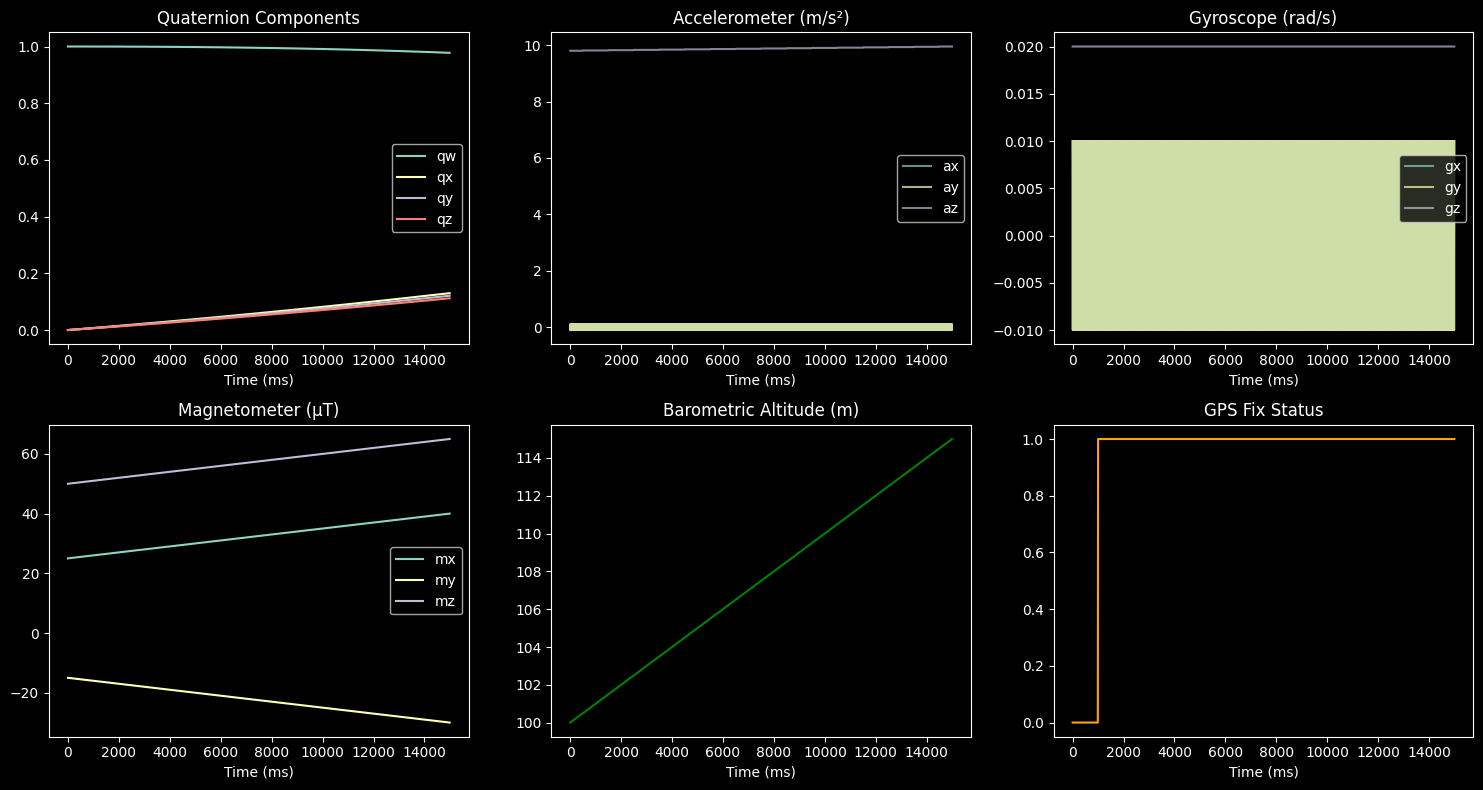

In [16]:
# Check for linear trends in various columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Quaternion components
axes[0, 0].plot(df['ms'], df['qw'], label='qw')
axes[0, 0].plot(df['ms'], df['qx'], label='qx')
axes[0, 0].plot(df['ms'], df['qy'], label='qy')
axes[0, 0].plot(df['ms'], df['qz'], label='qz')
axes[0, 0].set_title('Quaternion Components')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Time (ms)')

# Accelerometer
axes[0, 1].plot(df['ms'], df['ax'], label='ax', alpha=0.7)
axes[0, 1].plot(df['ms'], df['ay'], label='ay', alpha=0.7)
axes[0, 1].plot(df['ms'], df['az'], label='az', alpha=0.7)
axes[0, 1].set_title('Accelerometer (m/s²)')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Time (ms)')

# Gyroscope
axes[0, 2].plot(df['ms'], df['gx'], label='gx', alpha=0.7)
axes[0, 2].plot(df['ms'], df['gy'], label='gy', alpha=0.7)
axes[0, 2].plot(df['ms'], df['gz'], label='gz', alpha=0.7)
axes[0, 2].set_title('Gyroscope (rad/s)')
axes[0, 2].legend()
axes[0, 2].set_xlabel('Time (ms)')

# Magnetometer
axes[1, 0].plot(df['ms'], df['mx'], label='mx')
axes[1, 0].plot(df['ms'], df['my'], label='my')
axes[1, 0].plot(df['ms'], df['mz'], label='mz')
axes[1, 0].set_title('Magnetometer (µT)')
axes[1, 0].legend()
axes[1, 0].set_xlabel('Time (ms)')

# Altitude
axes[1, 1].plot(df['ms'], df['alt'], color='green')
axes[1, 1].set_title('Barometric Altitude (m)')
axes[1, 1].set_xlabel('Time (ms)')

# GPS Fix
axes[1, 2].plot(df['ms'], df['gps_fix'], color='orange')
axes[1, 2].set_title('GPS Fix Status')
axes[1, 2].set_xlabel('Time (ms)')

plt.tight_layout()
plt.show()

In [17]:
# Quantify the linear trends
print("=== Test Data Generation Patterns ===")
print()

# Altitude: linear increase
alt_slope = (df['alt'].iloc[-1] - df['alt'].iloc[0]) / (df['ms'].iloc[-1] - df['ms'].iloc[0])
print(f"Altitude: {df['alt'].iloc[0]:.2f} → {df['alt'].iloc[-1]:.2f} m")
print(f"  Slope: {alt_slope*1000:.4f} m/s (linear increase)")
print()

# Magnetometer: linear increase
for col in ['mx', 'my', 'mz']:
    slope = (df[col].iloc[-1] - df[col].iloc[0]) / (df['ms'].iloc[-1] - df['ms'].iloc[0]) * 1000
    print(f"{col}: {df[col].iloc[0]:.2f} → {df[col].iloc[-1]:.2f} µT (slope: {slope:.4f}/s)")
print()

# Accelerometer: oscillating noise around gravity
print(f"ax oscillates: {df['ax'].unique()[:5]} ...")
print(f"ay oscillates: {df['ay'].unique()[:5]} ...")
print(f"az: {df['az'].min():.2f} - {df['az'].max():.2f} m/s² (near gravity)")
print()

# GPS fix transition
gps_transition = df[df['gps_fix'].diff() != 0]['ms'].values
print(f"GPS fix transitions at: {gps_transition} ms")

=== Test Data Generation Patterns ===

Altitude: 100.01 → 115.00 m
  Slope: 1.0000 m/s (linear increase)

mx: 25.01 → 40.00 µT (slope: 1.0000/s)
my: -15.01 → -30.00 µT (slope: -1.0000/s)
mz: 50.01 → 65.00 µT (slope: 1.0000/s)

ax oscillates: [ 0.1 -0.1] ...
ay oscillates: [-0.1  0.1] ...
az: 9.80 - 9.95 m/s² (near gravity)

GPS fix transitions at: [   0 1000] ms


## 4. Trajectory Computation (Dead Reckoning)

Following the MATLAB analyzer approach:
1. Convert quaternion from NED to NEU frame (180° rotation around X axis)
2. Transform body-frame acceleration to world frame
3. Subtract gravity and integrate twice for position

In [18]:
def compute_trajectory(df):
    """Compute position via dead reckoning from IMU data.
    
    Matches the MATLAB dataanalyzer.m algorithm:
    - NED to NEU frame conversion
    - Accelerometer rotation to world frame
    - Gravity compensation
    - Double integration for position
    """
    g = 9.80665  # Gravity constant
    dt = 0.01    # 10ms timestep
    
    # Initialize state
    pos_NEU = np.zeros(3)
    vel_NEU = np.zeros(3)
    
    # Storage for results
    positions = []
    velocities = []
    euler_angles = []  # [yaw, pitch, roll]
    
    # Reference altitude (first reading)
    alt_home = df['alt'].iloc[0]
    
    # NED to NEU rotation: 180° around X axis
    # This flips Y and Z axes
    R_ned_to_neu = Rotation.from_euler('x', 180, degrees=True)
    
    for idx, row in df.iterrows():
        # Get quaternion (NED frame from filter)
        q_ned = Rotation.from_quat([row['qx'], row['qy'], row['qz'], row['qw']])  # scipy uses [x,y,z,w]
        
        # Convert to NEU frame
        q_neu = R_ned_to_neu * q_ned
        
        # Get Euler angles (ZYX order = yaw, pitch, roll)
        euler = q_neu.as_euler('ZYX', degrees=True)
        euler_angles.append(euler)  # [yaw, pitch, roll]
        
        # Body-frame acceleration
        accel_body = np.array([row['ax'], row['ay'], row['az']])
        
        # Rotate to world frame (NEU)
        accel_NEU = q_neu.apply(accel_body)
        
        # Subtract gravity (in NEU, gravity is [0, 0, -g])
        accel_NEU[2] -= g
        
        # Integrate velocity and position
        vel_NEU = vel_NEU + accel_NEU * dt
        pos_NEU = pos_NEU + vel_NEU * dt
        
        positions.append(pos_NEU.copy())
        velocities.append(vel_NEU.copy())
    
    # Convert to arrays
    positions = np.array(positions)
    velocities = np.array(velocities)
    euler_angles = np.array(euler_angles)
    
    # Relative altitude from barometer
    altitude = df['alt'].values - alt_home
    
    return {
        'time_ms': df['ms'].values,
        'pos_north': positions[:, 0],
        'pos_east': positions[:, 1],
        'pos_up': positions[:, 2],
        'altitude_baro': altitude,
        'yaw': euler_angles[:, 0],
        'pitch': euler_angles[:, 1],
        'roll': euler_angles[:, 2],
    }

# Compute trajectory
traj = compute_trajectory(df)
print("Trajectory computed!")
print(f"Position range - North: {traj['pos_north'].min():.1f} to {traj['pos_north'].max():.1f} m")
print(f"Position range - East: {traj['pos_east'].min():.1f} to {traj['pos_east'].max():.1f} m")
print(f"Altitude (baro): {traj['altitude_baro'].min():.1f} to {traj['altitude_baro'].max():.1f} m")

Trajectory computed!
Position range - North: 0.0 to 86.6 m
Position range - East: 0.0 to 83.5 m
Altitude (baro): 0.0 to 15.0 m


## 5. Visualization (Matching MATLAB Output)

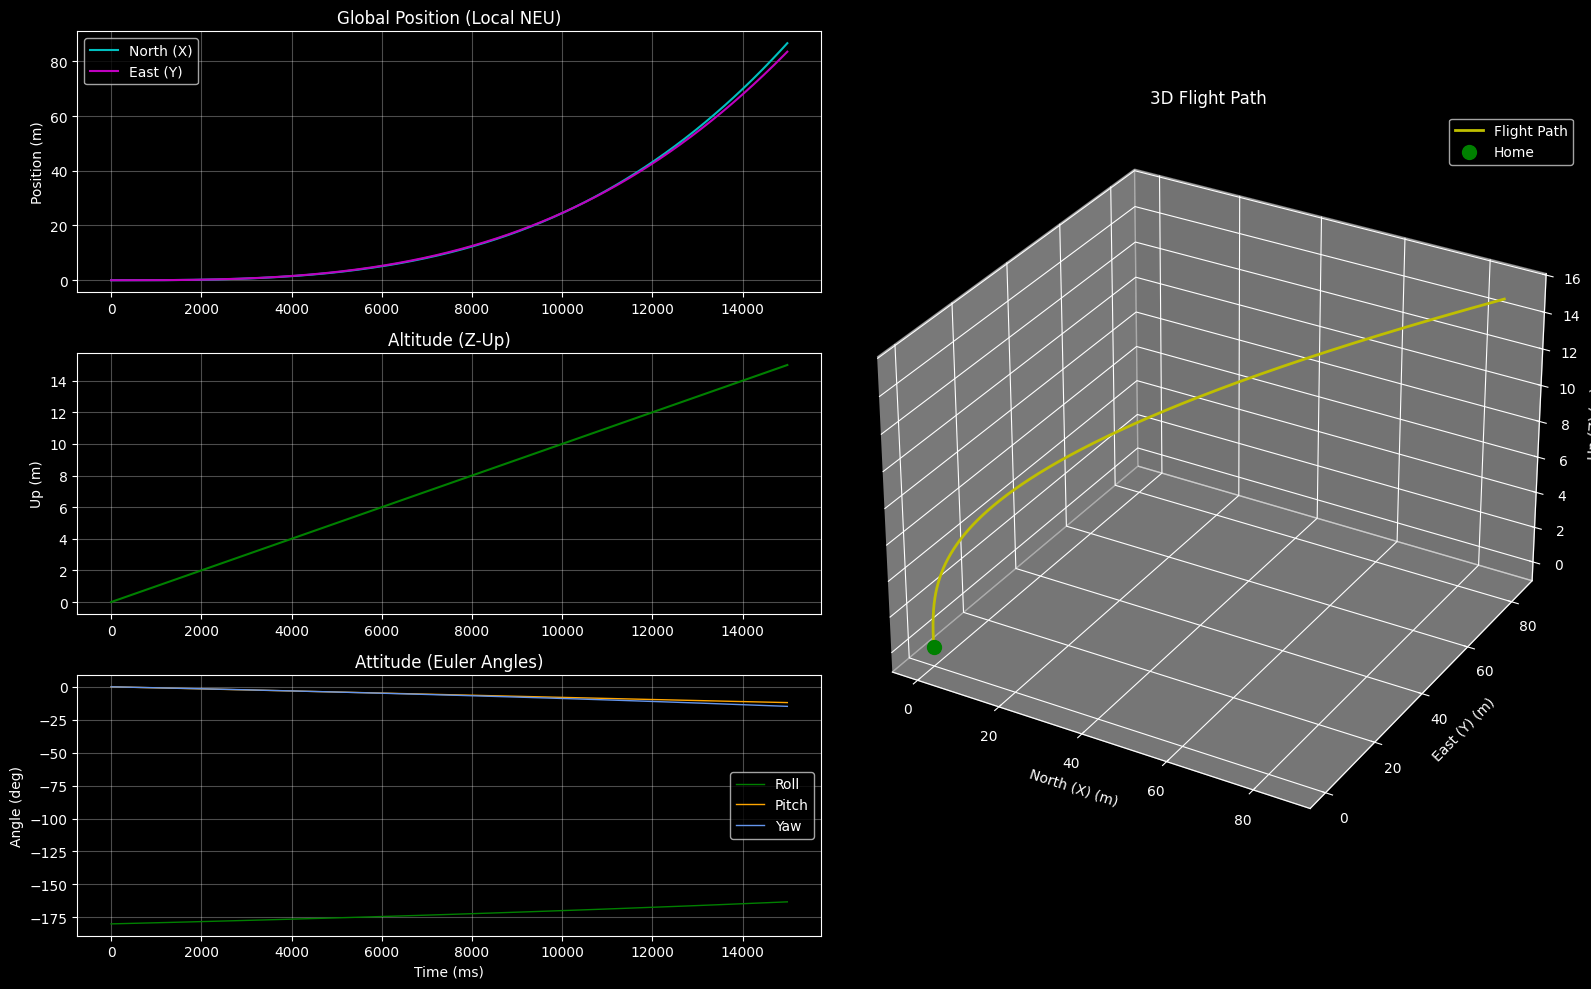

In [19]:
def plot_flight_analysis(traj):
    """Create visualization matching the MATLAB dataanalyzer.m output."""
    
    fig = plt.figure(figsize=(16, 10))
    
    # Left side: 2D time series (3 subplots)
    # Subplot 1: Global Position (Local NEU)
    ax1 = fig.add_subplot(3, 2, 1)
    ax1.plot(traj['time_ms'], traj['pos_north'], 'c-', linewidth=1.5, label='North (X)')
    ax1.plot(traj['time_ms'], traj['pos_east'], 'm-', linewidth=1.5, label='East (Y)')
    ax1.set_ylabel('Position (m)')
    ax1.set_title('Global Position (Local NEU)', color='white')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Altitude (Z-Up)
    ax2 = fig.add_subplot(3, 2, 3)
    ax2.plot(traj['time_ms'], traj['altitude_baro'], 'g-', linewidth=1.5)
    ax2.set_ylabel('Up (m)')
    ax2.set_title('Altitude (Z-Up)', color='white')
    ax2.grid(True, alpha=0.3)
    
    # Subplot 3: Attitude (Euler Angles)
    ax3 = fig.add_subplot(3, 2, 5)
    ax3.plot(traj['time_ms'], traj['roll'], 'g-', linewidth=1, label='Roll')
    ax3.plot(traj['time_ms'], traj['pitch'], color='orange', linewidth=1, label='Pitch')
    ax3.plot(traj['time_ms'], traj['yaw'], color='cornflowerblue', linewidth=1, label='Yaw')
    ax3.set_ylabel('Angle (deg)')
    ax3.set_xlabel('Time (ms)')
    ax3.set_title('Attitude (Euler Angles)', color='white')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Right side: 3D Flight Path
    ax4 = fig.add_subplot(1, 2, 2, projection='3d')
    ax4.plot(traj['pos_north'], traj['pos_east'], traj['altitude_baro'], 
             'y-', linewidth=2, label='Flight Path')
    ax4.scatter([0], [0], [0], color='green', s=100, marker='o', label='Home')
    ax4.set_xlabel('North (X) (m)')
    ax4.set_ylabel('East (Y) (m)')
    ax4.set_zlabel('Up (Z) (m)')
    ax4.set_title('3D Flight Path', color='white')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create the visualization
fig = plot_flight_analysis(traj)

## 6. Summary: Test Data Generation Algorithm

Based on the analysis, the test data appears to be generated with these patterns:

### Detected Patterns
1. **Timestamp**: Linear 10ms increments (100Hz)
2. **Quaternion**: Slowly drifting rotation (small increments in x,y,z components)
3. **Accelerometer**: 
   - ax, ay: Oscillating noise (±0.10 m/s²)
   - az: Near gravity (~9.8-9.95 m/s²), slight increase over time
4. **Gyroscope**: Small noise values (±0.01-0.02 rad/s)
5. **Magnetometer**: Linear increase (all components increment by 0.01 per sample)
6. **Altitude**: Linear increase from 100m to 115m
7. **GPS Fix**: Transitions from 0→1 partway through

In [20]:
# Document the generation patterns for the path simulator
generation_params = {
    'sample_rate_hz': 100,
    'duration_s': 15,
    'altitude': {
        'start_m': 100,
        'end_m': 115,
        'pattern': 'linear'
    },
    'quaternion': {
        'pattern': 'slow_drift',
        'drift_rate': 0.0001  # per sample increment in x,y,z
    },
    'accelerometer': {
        'xy_noise': 0.10,  # m/s², oscillating
        'z_base': 9.80,    # gravity
        'z_drift': 0.15    # total drift over duration
    },
    'gyroscope': {
        'noise': 0.02  # rad/s
    },
    'magnetometer': {
        'start': [25, -15, 50],  # µT
        'drift_per_sample': 0.01
    },
    'gps_fix': {
        'transition_time_ms': 7000  # approximate
    }
}

print("Generation Parameters (for path_simulator.py):")
for key, value in generation_params.items():
    print(f"  {key}: {value}")

Generation Parameters (for path_simulator.py):
  sample_rate_hz: 100
  duration_s: 15
  altitude: {'start_m': 100, 'end_m': 115, 'pattern': 'linear'}
  quaternion: {'pattern': 'slow_drift', 'drift_rate': 0.0001}
  accelerometer: {'xy_noise': 0.1, 'z_base': 9.8, 'z_drift': 0.15}
  gyroscope: {'noise': 0.02}
  magnetometer: {'start': [25, -15, 50], 'drift_per_sample': 0.01}
  gps_fix: {'transition_time_ms': 7000}
